# Define the system  

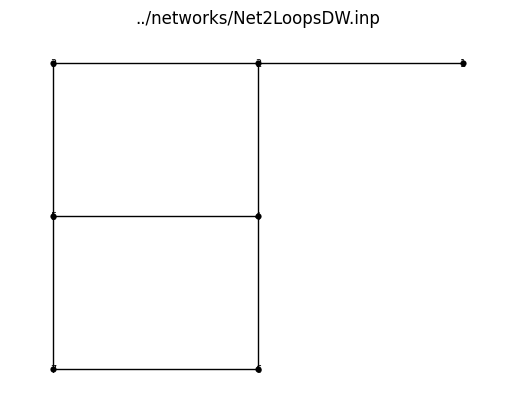

<Axes: title={'center': '../networks/Net2LoopsDW.inp'}>

In [26]:
import wntr
import wntr_quantum

# Create a water network model
inp_file = '../networks/Net0.inp'
inp_file = '../networks/Net2LoopsDW.inp'
wn = wntr.network.WaterNetworkModel(inp_file)

# Graph the network
wntr.graphics.plot_network(wn, title=wn.name, node_labels=True)


## Run with the original Cholesky EPANET simulator

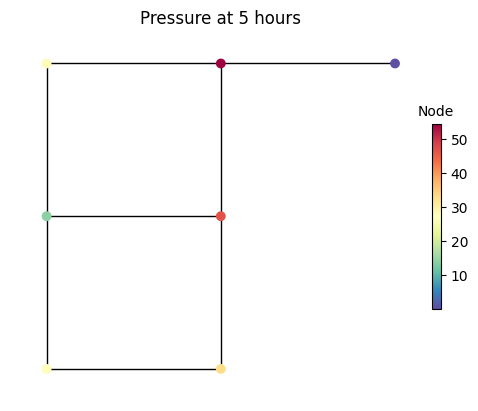

<Axes: title={'center': 'Pressure at 5 hours'}>

In [27]:
sim = wntr.sim.EpanetSimulator(wn)
results = sim.run_sim()
# Plot results on the network
pressure_at_5hr = results.node['pressure'].loc[0, :]
wntr.graphics.plot_network(wn, node_attribute=pressure_at_5hr, node_size=50,
                        title='Pressure at 5 hours', node_labels=False)

In [28]:
pressure_at_5hr

name
2    5.446573e+01
3    2.785345e+01
4    4.665007e+01
5    1.385757e+01
6    3.296196e+01
7    2.745172e+01
1    4.394531e-07
Name: 0, dtype: float32

## Run with our custom Cholesky EPANET solver 
we use the default solver of the QuantumWNTRSimulator, that uses a LU solver, a s a benchmark of the calculation

/home/nico/QuantumApplicationLab/vitens/wntr-quantum/wntr_quantum/epanet/Linux/libepanet22_amd64.so
DW - TURBULENT
DW - TURBULENT
DW - TURBULENT
DW - TURBULENT
DW - TURBULENT
DW - TURBULENT
DW - TURBULENT
DW - TURBULENT
DW - TURBULENT
DW - TURBULENT
DW - TURBULENT
DW - TURBULENT
DW - TURBULENT
DW - TURBULENT
DW - TURBULENT
DW - TURBULENT
DW - TURBULENT
DW - TURBULENT
DW - TURBULENT
DW - TURBULENT
DW - TURBULENT
DW - TURBULENT
DW - TURBULENT
DW - TURBULENT
DW - TURBULENT
DW - TURBULENT
DW - TURBULENT
DW - TURBULENT
DW - TURBULENT
DW - TURBULENT
DW - TURBULENT
DW - TURBULENT


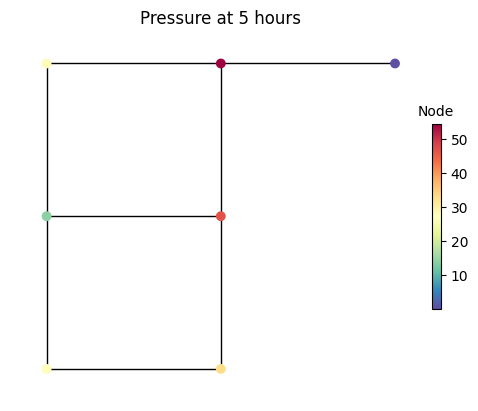

<Axes: title={'center': 'Pressure at 5 hours'}>

In [29]:
import os 
os.environ["EPANET_TMP"] = "/home/nico/.epanet_quantum"
os.environ["EPANET_QUANTUM"] = "/home/nico/QuantumApplicationLab/vitens/EPANET"
sim = wntr_quantum.sim.QuantumEpanetSimulator(wn)
results = sim.run_sim()
# Plot results on the network
pressure_at_5hr = results.node['pressure'].loc[0, :]
wntr.graphics.plot_network(wn, node_attribute=pressure_at_5hr, node_size=50,
                        title='Pressure at 5 hours', node_labels=False)

## Run with the AEQUBOLS solver

/home/nico/QuantumApplicationLab/vitens/wntr-quantum/wntr_quantum/epanet/Linux/libepanet22_amd64.so
Solving the linear system Ax = b with:
A =  [[ 0.1155474 -0.1155474]
 [-0.1155474  2.454284 ]]
b =  [ -1.614401 230.2773  ]
x =  [77.95698925 97.50733138]
residue =  0.645100575394777
Solving the linear system Ax = b with:
A =  [[ 0.0203655 -0.0203655]
 [-0.0203655  0.6378524]]
b =  [-0.6197366 60.7565   ]
x =  [62.31671554 97.2629521 ]
residue =  0.09299011493672167
Solving the linear system Ax = b with:
A =  [[ 0.02591948 -0.02591948]
 [-0.02591948  0.8072867 ]]
b =  [-0.8891007 76.89368  ]
x =  [62.8054741 97.2629521]
residue =  0.004721498046104942
Solving the linear system Ax = b with:
A =  [[ 0.02710065 -0.02710065]
 [-0.02710065  0.8371059 ]]
b =  [-0.9318042 79.72048  ]
x =  [62.31671554 97.2629521 ]
residue =  0.018294070336562634


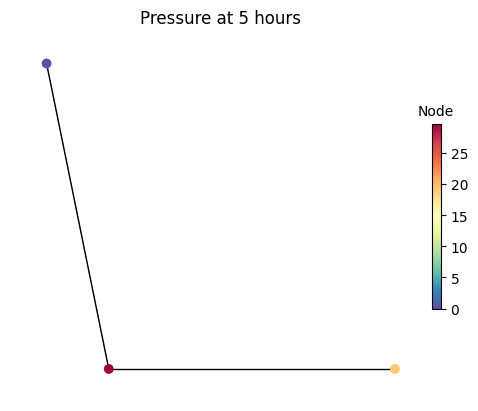

<Axes: title={'center': 'Pressure at 5 hours'}>

In [19]:
from quantum_newton_raphson.qubo_solver import QUBO_SOLVER

linear_solver = QUBO_SOLVER(
    num_qbits=11,
    num_reads=250,
    # iterations=5,
    range=250,
    offset=0,
    # temperature=1e4,
    use_aequbols=False,
)

sim = wntr_quantum.sim.QuantumEpanetSimulator(wn, linear_solver=linear_solver)
results = sim.run_sim(linear_solver=linear_solver)

# Plot results on the network
pressure_at_5hr = results.node['pressure'].loc[0, :]
wntr.graphics.plot_network(wn, node_attribute=pressure_at_5hr, node_size=50,
                        title='Pressure at 5 hours', node_labels=False)

In [20]:
pressure_at_5hr

name
J1    2.964575e+01
D1    1.914311e+01
R1   -9.338379e-07
Name: 0, dtype: float32

In [8]:
import sys
import os 
epanet_path = os.environ["EPANET_QUANTUM"]
epanet_tmp = os.environ["EPANET_TMP"]
util_path = os.path.join(epanet_path, 'src/py/')
sys.path.append(util_path)
from quantum_linsolve import load_json_data 
A, b = load_json_data(os.path.join(epanet_tmp,'smat.json'))

In [42]:
from quantum_newton_raphson.qubo_solver import QUBO_SOLVER
linear_solver = QUBO_SOLVER(
    num_qbits=13,
    num_reads=500,
    # iterations=5,
    range=250,
    offset=0,
    # temperature=1e4,
    use_aequbols=False,
)

In [43]:
qubo_sol = linear_solver(A, b)

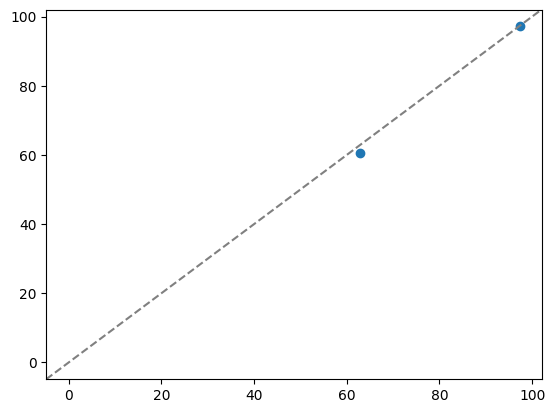

In [44]:
import numpy as np 
import matplotlib.pyplot as plt 
np_sol = np.linalg.solve(A.todense(), b)
plt.scatter(np_sol, qubo_sol.solution)
plt.axline((0, 0), slope=1, linestyle="--", color="gray")
plt.show()

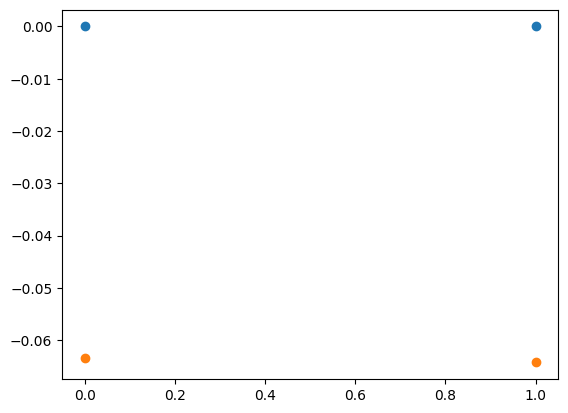

In [45]:
plt.scatter( list(range(2)), (A@np_sol-b))
plt.scatter(list(range(2)), (A@qubo_sol.solution-b))

In [51]:
from quantum_newton_raphson.vqls_solver import VQLS_SOLVER
from vqls_prototype import VQLS
from qiskit.primitives import Estimator
from qiskit.circuit.library import RealAmplitudes 
from qiskit_algorithms.optimizers import CG
qc = RealAmplitudes(2, reps=3, entanglement='full')
estimator = Estimator()

vqls = VQLS(
    estimator,
    qc,
    CG(),
    options={"matrix_decomposition" : "pauli"}
)
# res = vqls.solve(A.todense(),b)

In [52]:
from vqls_prototype.matrix_decomposition import PauliDecomposition, SymmetricDecomposition
pd = PauliDecomposition(A)

100%|██████████| 4/4 [00:00<00:00, 231.54it/s]
